<a href="https://colab.research.google.com/github/dharm1k987/tensorflow_projects/blob/master/tensorflow_face_emotion_classification/Face%20Emotion%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')
%matplotlib inline

# Download the Data

In [4]:
# data initially from kaggle but I stored on mediafire so we could download easily
# about 300MB csv file
!echo Downloading...
!curl -L \
    "https://github.com/dharm1k987/tensorflow_projects/raw/master/tensorflow_face_emotion_classification/fer2013.zip" \
    -O && echo Done downloading || echo Error occurred

Downloading...
Done downloading 


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   188  100   188    0     0    188      0  0:00:01 --:--:--  0:00:01   926

  1 89.5M    1 1191k    0     0  1191k      0  0:01:16 --:--:--  0:01:16 1191k
  7 89.5M    7 7255k    0     0  7255k      0  0:00:12  0:00:01  0:00:11 6064k
 15 89.5M   15 14.1M    0     0  7251k      0  0:00:12  0:00:02  0:00:10 6656k
 24 89.5M   24 22.1M    0     0  7554k      0  0:00:12  0:00:03  0:00:09 7157k
 34 89.5M   34 31.1M    0     0  7961k      0  0:00:11  0:00:04  0:00:07 7664k
 45 89.5M   45 40.5M    0     0  8305k      0  0:00:11  0:00:05  0:00:06 8067k
 56 89.5M   56 50.7M    0     0  8667k      0  0:00:10  0:00:06  0:00:04 8950k
 68 89.5M   68 61.2M    0     0  8956k      0  0:00:10  0:00:07  0:00:03 9638k
 81 89.5M   81 73.0M    0     0  9354k      0  0:0

In [5]:
!ls

Face Emotion Classification.ipynb
fer2013.zip


In [8]:
!unzip "./fer2013.zip"
!ls

Archive:  ./fer2013.zip
  inflating: fer2013.csv             
Face Emotion Classification.ipynb
fer2013.csv
fer2013.zip


# View Data

In [9]:
data = pd.read_csv('./fer2013.csv')
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [10]:
print('Total emotions: {}'.format(data.emotion.unique()))
print('Total amount of data: {}'.format(len(data.emotion)))
print('Total amount of pixels per image: {}'.format(len(data.loc[0].pixels.split(' ')))) # 48 x 48

Total emotions: [0 2 4 6 3 5 1]
Total amount of data: 35887
Total amount of pixels per image: 2304


# Show Images

In [11]:
# helper function to extract the pixels from the dataframe
def extract_pixels(pixels):
    pixels = pixels.split(' ')
    pixels = np.array([int(i) for i in pixels])
    return np.reshape(pixels, (48, 48))/255

# helper function to showcase the images
def img_helper(rows, df):
    fig = plt.figure(figsize=(8,10))
    idx = 0
    for i, row in df.iterrows():
        input_img = extract_pixels(row.pixels)
        ax = fig.add_subplot(5,5,idx+1)
        ax.imshow(input_img, cmap=matplotlib.cm.gray)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.tight_layout()
        idx += 1
    plt.show()

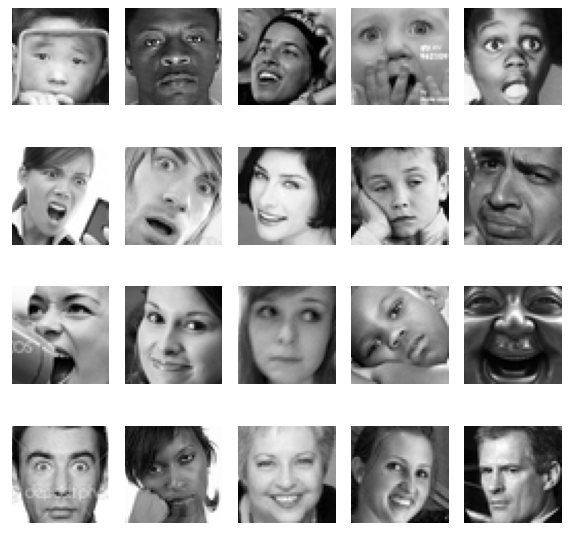

In [12]:
# show 25 images
img_helper(25, data.sample(n=20))

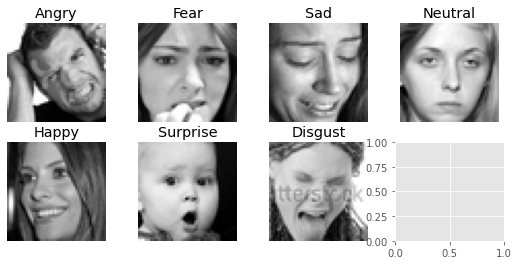

In [13]:
# show all the emotions
emotion_name = {0:"Angry", 1:"Disgust", 2:"Fear", 3:"Happy", 4:"Sad", 5:"Surprise", 6:"Neutral"}
unique_emotions = data.emotion.unique()

images = []
emotions = []
# select 1 image which matches each emotion
for emotion in unique_emotions:
    emotion_df = data[data.emotion == emotion].sample(n=1)
    emotions.append(emotion)
    
    pixels = emotion_df['pixels']
    images.append(extract_pixels(pixels.to_list()[0]))
    
cols = 4
fig, ax = plt.subplots(len(images) // cols + 1, cols, figsize=(9,4))
for i,img in enumerate(images):
    row = i // cols
    col = i % cols
    ax[row, col].imshow(img, cmap=matplotlib.cm.gray)
    ax[row, col].axis('off')
    ax[row, col].set_title(emotion_name[emotions[i]])

In [14]:
# view distributions of emotions
emotion_counts = data['emotion'].value_counts().sort_index()
emotion_counts

0    4953
1     547
2    5121
3    8989
4    6077
5    4002
6    6198
Name: emotion, dtype: int64

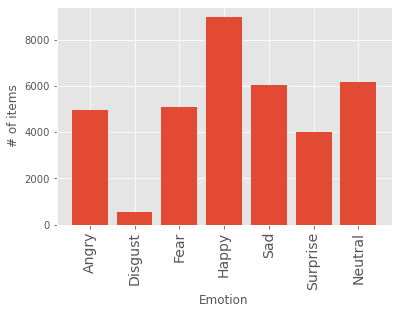

In [15]:
plt.bar(range(0, len(emotion_counts)), emotion_counts)
plt.ylabel('# of items')
plt.xlabel('Emotion')
plt.xticks(np.arange(7), [emotion_name[i] for i in range(len(emotion_counts))], rotation=90, fontsize=14)
plt.show()

# Split into Training and Testing

In [16]:
from sklearn.model_selection import train_test_split

# go through each row in the dataframe and grab the pixels
X = [
     extract_pixels(row.pixels)
     for index, row in data.iterrows()
]

X = np.array(X)
Y = np.array(data['emotion'])

print(X.shape)
print(Y.shape)
print(Y[0])

(35887, 48, 48)
(35887,)
0


In [17]:
# reshape our data to be 4D because our model requires it
X = X.reshape(-1, 48, 48, 1)
X.shape

(35887, 48, 48, 1)

In [18]:
# now split it into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(28709, 48, 48, 1)
(7178, 48, 48, 1)
(28709,)
(7178,)


In [19]:
# since we are using softmax, we have to one hot encode the y
y_train = tf.keras.utils.to_categorical(y_train, 7)
y_test = tf.keras.utils.to_categorical(y_test, 7)

# Create Model

In [20]:
from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout ,Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [21]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(48, 48, 1)),

    # conv layer and pooling
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(256, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(512, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dropout(0.5),

    # flatten and add dense layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    # last layer
    tf.keras.layers.Dense(len(emotion_counts), activation='softmax')
])

In [25]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
# if we use image generator then we can augment the images
generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range = 0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True,
    channel_shift_range=0.1,
    rescale=1.2
)

In [23]:
generator.fit(X_train)

In [ ]:
batch_size = 128

# augmentation
aug = False

# if we have this on, we will train using the generator# this takes much longer, but it gives us many augmented images# and thus a better model
if aug:
    model.fit_generator(
        generator.flow(X_train, y_train, batch_size = batch_size),
        steps_per_epoch = int(len(X_train) / batch_size + 1),
        epochs = 200,
        validation_data = (X_test, y_test),
        verbose = 2
    )

# otherwise train using the model only
else:
    model.fit(
        x = X_train,
        y = y_train,
        batch_size = 64,
        epochs = 50,
        verbose = 1,
        validation_data = (X_test, y_test),
    )

Epoch 1/50
449/449 [==============================] - 306s 681ms/step - loss: 2.0335 - accuracy: 0.3048 - val_loss: 1.6962 - val_accuracy: 0.3009
Epoch 2/50
131/449 [=======>......................] - ETA: 3:26 - loss: 1.4845 - accuracy: 0.4253

# Testing

In [ ]:
def img_helper_test(rows, df):
    fig = plt.figure(figsize=(8,8))
    idx = 0
    df_elements = df.sample(n=rows)
    for i, row in df_elements.iterrows():
        input_img = extract_pixels(row.pixels)
        ax = fig.add_subplot(6,6,idx+1)
        ax.imshow(input_img, cmap=matplotlib.cm.gray)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.tight_layout()
        idx += 1
        
        # if our prediction matches the real emotion, print green text, else red
        color = "red"
        pred = np.argmax(model.predict(input_img.reshape(1, 48, 48, 1)), axis=-1)[0]
        if emotion_name[pred] == emotion_name[row.emotion]:
            color = "green"
        plt.xlabel('Pred: {}'.format(emotion_name[pred]))
        plt.title('Real: {}'.format(emotion_name[row.emotion]), fontsize=12, color=color)
    plt.show()

In [ ]:
img_helper_test(36, data)
img_helper_test(24, data)

In [ ]:
b = "3"
!echo "$b"

In [ ]:
# you need to be on google colab for this to work
from google.colab.patches import cv2_imshow
import cv2

def own_image_test(img_url):
    # fetch the image and save it locally 
    !curl -o logo.png $img_url
    img = cv2.imread('logo.png', cv2.IMREAD_UNCHANGED)

    # display it to the user, and resize it to 48x48
    cv2_imshow(cv2.resize(img, (300, 300)))
    img = cv2.resize(img, (48, 48))

    # convert to grayscale, and do some more adjusting
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255
    img = img.reshape(1, 48, 48, 1)

    # predict the emotion
    model.predict(img)
    pred = model.predict(img)
    emotion_name[np.argmax(pred, axis=-1)[0]]

    # display in a graph
    plt.bar(range(0, len(emotion_counts)), pred[0])
    plt.ylabel('Probability')
    plt.xlabel('Emotion')
    plt.xticks(np.arange(7), [emotion_name[i] for i in range(len(emotion_counts))], rotation=90, fontsize=14)
    plt.show()

In [ ]:
own_image_test("https://wallpaper-house.com/data/out/10/wallpaper2you_443897.jpg")